In [77]:
# Set overlap utility function
import numpy as np
import pandas as pd
import rbo
import matplotlib.pyplot as plt 

def print_set_overlap(ranking1, treatment_vars, k, nTreatment):
    """
    Provide the correlation analysis of top-k features from the following two:
    1. ranking1: List of ranking provided by the ranking method, 
    2. treatment_vars: list of set of treatment variables. Each set contains the treatment variables that are 
    changing for that datapoint.
    size of 1&2 = number of data points each element is a ranking of features
            
    returns pd.Series(rank based overlap)
    Prints the Series analysis of rank correlation values between both the rankings
    (Mean, std, Min, 25%, 50%, 75%, Max, Histogram)
    """
    overlap_values = []
    idx_arr = np.arange(len(ranking1))
    for r1, r2 in zip(ranking1, treatment_vars):
        if nTreatment == len(r2):
            # Sorting the rankings in descending order of the absolute attribution values.
            contributions = set([attr_value[1] for attr_value in 
                            sorted(zip(r1, idx_arr), key=lambda temp: -abs(temp[0]))][:k])

            overlap_len = len(contributions.intersection(r2))
            if(len(r2)==0):
                overlap = 1
            else:
                overlap = overlap_len/len(r2)

            overlap_values.append(overlap)
    
    return pd.Series(overlap_values) 

def calculate_accuracy(SHAPminusBaseline, TIminusBaseline, data_x, Baseline_x,k, nTreatment):
    treatment_vars = [10,11,12]
    treatment_vars_data = [4,5,6]
    SHAPminusBaseline_df = pd.read_csv(SHAPminusBaseline,header=None,sep=',')
    TIminusBaseline_df = pd.read_csv(TIminusBaseline,header=None,sep=',')
    
    
    SHAPminusBaseline_df = SHAPminusBaseline_df.drop(0,1)
    SHAPminusBaseline_df = SHAPminusBaseline_df.drop(0,0)
    SHAPminusBaseline_df.columns = range(0,13)
    SHAPminusBaseline_df = SHAPminusBaseline_df.convert_objects(convert_numeric=True)


    TIminusBaseline_df = TIminusBaseline_df.drop(0,1)
    TIminusBaseline_df = TIminusBaseline_df.drop(0,0)
    TIminusBaseline_df.columns = range(0,13)
    TIminusBaseline_df = TIminusBaseline_df.convert_objects(convert_numeric=True)

    
    
    data_x_df = pd.read_csv(data_x)
    Baseline_x_arr = np.array(pd.read_csv(Baseline_x,header=None)[0].tolist())
    
    # Getting just the treatment values from the x variables
    data_x_df_treatment = data_x_df.iloc[:,treatment_vars_data]
    data_x_df_treatment.columns = treatment_vars
    
    # Contains false if the treatment variable is not the same as the baseline
    treatment_df = (Baseline_x_arr[treatment_vars].astype(int) == data_x_df_treatment) 
    
    aList = []
    for _,row in treatment_df.iterrows():
        
        treated = set()
        for col in treatment_df:
            if row[col]==False:
                treated.add(col)
        aList.append(treated)
        
    SHAP_series = print_set_overlap(SHAPminusBaseline_df.to_numpy(),aList,k,nTreatment)
    TI_series = print_set_overlap(TIminusBaseline_df.to_numpy(),aList,k,nTreatment)
    return (SHAP_series,TI_series)

In [78]:
# LOOP OVER ALL IMAGES!
import glob
import os
import re


def accuracy_all_files(top_n):
#     top_n: Calculate accuracy for top_n number of attributes accounted for by the model
    garage_diff = "./diffInterpretations_templates_randomBaseline/"
    garage_data = "./Test_subset/"
    SHAPminusBaseline_files = glob.glob(garage_diff + "*SHAP_outs*test*")
    TIminusBaseline_files = glob.glob(garage_diff + "TI*test*")
    Baseline_files = glob.glob(garage_diff + "*SHAP_baseline*test*")

    SHAPminusBaseline_file = SHAPminusBaseline_files[1]
    set_overlap_list_SHAP = []
    set_overlap_list_TI = []
    for Baseline_file in Baseline_files:
        # SHAP
        SHAPminusBaseline_file = re.sub("_baseline_*\d+", "", Baseline_file)
        # TI
        TIminusBaseline_file = garage_diff + os.path.basename(SHAPminusBaseline_file).replace("SHAP", "TI")
        # Data
        testData_x = garage_data + "covComb" + os.path.basename(SHAPminusBaseline_file).strip("diffInterpreted_SHAP_outs_mb").strip("_test.txt") + "_test.csv"

        SHAP_current_set_overlap, TI_current_set_overlap = calculate_accuracy(SHAPminusBaseline_file, TIminusBaseline_file,testData_x,Baseline_file,3,top_n)

        set_overlap_list_SHAP.extend(SHAP_current_set_overlap)
        set_overlap_list_TI.extend(TI_current_set_overlap) 
    return set_overlap_list_SHAP,set_overlap_list_TI

In [79]:
def plot_fn(set_overlap_list_SHAP,set_overlap_list_TI):
    print("SHAP describe: ",pd.Series(set_overlap_list_SHAP).describe())
    print("Median: ",pd.Series(set_overlap_list_SHAP).median())
    plt.hist(set_overlap_list_SHAP)
    plt.xlabel("Set overlap SHAP")
    plt.ylabel("Number of datapoints")
    plt.show()



    print("TI describe: ",pd.Series(set_overlap_list_TI).describe())
    print("Median: ",pd.Series(set_overlap_list_TI).median())

    plt.hist(set_overlap_list_TI)
    plt.xlabel("Set overlap TI")
    plt.ylabel("Number of datapoints")
    plt.show()

/Users/testaccount/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Users/testaccount/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


SHAP describe:  count    4794.000000
mean        0.722570
std         0.447777
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64
Median:  1.0


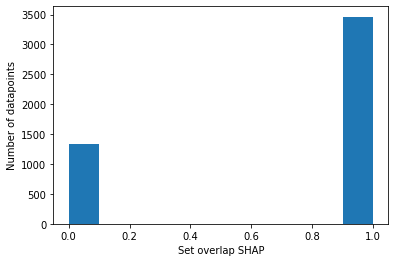

TI describe:  count    4794.000000
mean        0.783479
std         0.411916
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64
Median:  1.0


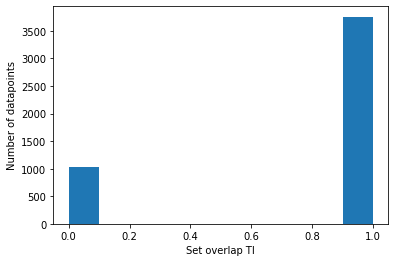

In [80]:
set_overlap_list_SHAP, set_overlap_list_TI = accuracy_all_files(1)
plot_fn(set_overlap_list_SHAP, set_overlap_list_TI)

/Users/testaccount/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Users/testaccount/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


SHAP describe:  count    10538.000000
mean         0.467783
std          0.252220
min          0.000000
25%          0.500000
50%          0.500000
75%          0.500000
max          1.000000
dtype: float64
Median:  0.5


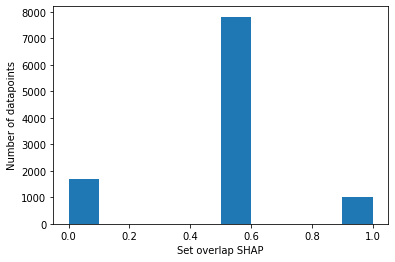

TI describe:  count    10538.000000
mean         0.552524
std          0.301947
min          0.000000
25%          0.500000
50%          0.500000
75%          0.500000
max          1.000000
dtype: float64
Median:  0.5


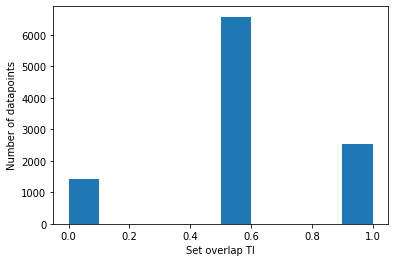

In [81]:
set_overlap_list_SHAP, set_overlap_list_TI = accuracy_all_files(2)
plot_fn(set_overlap_list_SHAP, set_overlap_list_TI)

/Users/testaccount/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Users/testaccount/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


SHAP describe:  count    5988.000000
mean        0.355266
std         0.159574
min         0.000000
25%         0.333333
50%         0.333333
75%         0.333333
max         1.000000
dtype: float64
Median:  0.3333333333333333


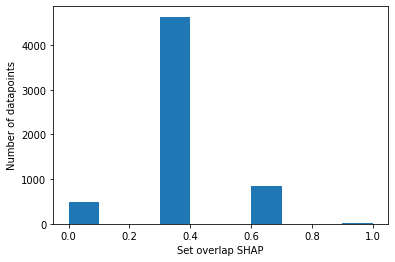

TI describe:  count    5988.000000
mean        0.361835
std         0.193630
min         0.000000
25%         0.333333
50%         0.333333
75%         0.333333
max         1.000000
dtype: float64
Median:  0.3333333333333333


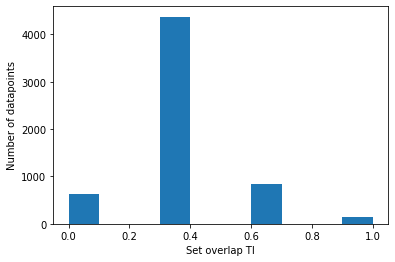

In [82]:
set_overlap_list_SHAP, set_overlap_list_TI = accuracy_all_files(3)
plot_fn(set_overlap_list_SHAP, set_overlap_list_TI)